In [2]:
# imports libraries
import pickle										# import/export lists
import datetime										# dates
import string										# string parsing
import re 											# regular expression
import pandas as pd									# dataframes
import numpy as np									# numerical computation
import matplotlib.pyplot as plt						# plot graphics
import nltk											# natural language process
from nltk.corpus import stopwords					# stop words
from nltk import word_tokenize						# word tokens
from nltk.util import ngrams						# ngrams
import seaborn as sns								# graphics supplemental

In [3]:
# opens raw data
with open ('../clean_data/df_profile', 'rb') as fp:
    df = pickle.load(fp)
    
# creates subset of data of active users
df_active = df.loc[df.status != 'inactive', ].copy()

# sets current year
cyear = datetime.datetime.now().year

# sets stop word list for text parsing
stop_word_list = stopwords.words('english')

# User Analysis

In this section, we take a sample of ~10,000 users from fanfiction.net and break down some of their characteristics.

## Activity and volume

Let's begin by examining the types of profiles that make up the userbase: readers, authors, or inactive users. Inactive users are accounts that are no longer existing.

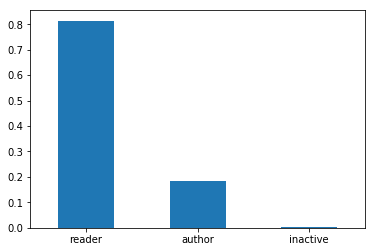

In [4]:
# examines status of users
status = df['status'].value_counts()

# plots chart
(status/np.sum(status)).plot.bar()
plt.xticks(rotation=0)
plt.show()

About ~20% of users on the site are authors! That's much higher than expected. The number of inactive profiles is also notably negligible, meaning that once a profile has been created, it is very unlikely to be ever deleted or pulled off the site. 

How about fast people are joining the site?

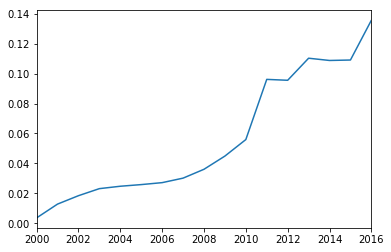

In [5]:
# examines when stories first created
entry = [int(row[2]) for row in df_active['join'] if row != 'NA']
entry = pd.Series(entry).value_counts().sort_index()

# plots chart
(entry/np.sum(entry)).plot()
plt.xlim([np.min(entry.index.values), cyear-1])
plt.show()

Note that sharp increase in 2011! Wonder what could have caused that surge...

## Countries

The site fanfiction.net allows tracking of location for users. Let's examine where these users are from.

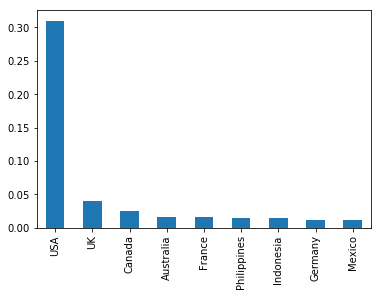

In [6]:
# examines distribution of top 10 countries
country = df['country'].value_counts()
(country[1:10]/np.sum(country)).plot.bar()
plt.xticks(rotation=90)

plt.show()

We looked at the top 10 countries. Over ~30% are from United States!

## Profile descriptions

Users have the option of including a profile description. Let's see what percentage of the active userbase has them. 

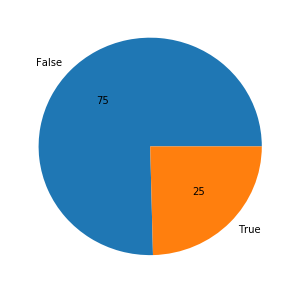

In [7]:
hasprofile = [row != '' for row in df_active['profile']]
profiletype = pd.Series(hasprofile).value_counts()
profiletype.plot.pie(autopct='%.f', figsize=(5,5))

plt.ylabel('')
plt.show()

It would appear about one-fourth of the users have written something in their profile! For those who have, let's see how many words they have written.

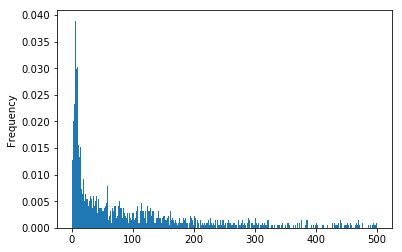

In [8]:
# examines word count of profiles
# IMPORTANT NOTE: 'request' package has error in which it cannot find end p tag </p>, thus 
# leading to description duplicates i some profiles. Until this error is addressed, an abritrary 
# cutoff is used.
profile_wc = [len(row.split()) for row in df_active['profile']]

pd.Series(profile_wc).plot.hist(normed=True, bins=np.arange(1, 500, 1))

plt.show()

The right tail is much longer than depicted, with ~3% of profiles exceeding our 500 word cut off. However, it would appear the majority of profiles fall well under 100-200 words.

What about what they say, if they do say something? Let's see what are the top 10 words commonly used. These are the words most likely to be used at least once in a profile description. And of course, this is excluding stop words, such as "the", "is", or "are".

In [9]:
# extracts mostly used common words
profile_wf = [set(row.lower().translate(str.maketrans('', '', string.punctuation)).split()) 
              for row in df_active.loc[hasprofile, 'profile']]
profile_wf = [item for sublist in profile_wf for item in sublist]
profile_wf = pd.Series(profile_wf).value_counts()

In [10]:
stop_word_list.append('im')
stop_word_list.append('dont')
print((profile_wf.loc[[row not in stop_word_list 
                        for row in profile_wf.index.values]][:10]/sum(hasprofile)).to_string())

like       0.315661
love       0.286297
one        0.250816
stories    0.241436
know       0.234095
writing    0.223491
write      0.216558
time       0.213703
name       0.207586
read       0.197390


Likes and dislikes, reading and writing. Very standard introduction words for a community like fanfiction.

The word "name" also made the list. We calculated and estimated it to be in ~21% of profiles that have something written. This prompts the question of what other information we might parse out. We looked into "gender"/"sex" and estimated ~6%. As for "age"/"old", also ~20%

In [11]:
name_count = (profile_wf['name'])/sum(hasprofile)
gender_count = (profile_wf['gender']+profile_wf['sex'])/sum(hasprofile)
age_count = (profile_wf['age']+profile_wf['old'])/sum(hasprofile)

## Gender

Now this is where things get tricky. So we've discovered that ~25% of users written something in their profiles. For those users, we want to figure out 1) if they have disclosed their gender, 2) get the machine to recognize what that gender is. For this exercise, we will only examine users who have disclosed in English.

We start with the most basic approach, which is to search for the key words "female" and "male", then count how many profiles have one word but not the other.

In [39]:
profile_text = [list(set(row.lower().translate(str.maketrans('', '', string.punctuation)).split())) 
              for row in df_active.loc[hasprofile, 'profile']]

In [52]:
female = ['female' in row and 'male' not in row for row in profile_text]
male = ['male' in row and 'female' not in row for row in profile_text]
gender = pd.Series([sum(female), sum(male)], index = ['female', 'male'])

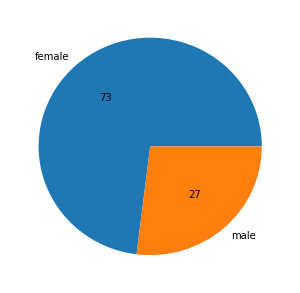

In [53]:
gender.plot.pie(autopct='%.f', figsize=(5,5))

plt.ylabel('')
plt.show()

It should be noted that third-gender and non-binary words were also tested but yielded too little observations for analysis. As such, everything we talk about below is only in reference to the female and male genders.

Assuming a user is either "female" or "male", we estimate a rough 3:1 ratio, favoring female.

This may or may not reflect gender ratio of the actual userbase. Here, we are making a lot of assumptions, including:
* Female and male users are equally likely to write something in their profile.
* Female and male users are equally likely to disclose their gender in their profile.
* Female and male users are equally likely to choose the words "female" or "male" for disclosing their gender.
* The words "female" or "male" are primarily used in the context of gender self-identification.

We decided to do a check against other gender-related words that might be potential identifiers. The below reveal the proportion of written profiles that contain each word. Note that one profile can contain both the female-specific and male-specific word.

In [55]:
female = ['female', 'girl', 'woman', 'daughter', 'mother', 'sister']
male = ['male', 'boy', 'man', 'son', 'father', 'brother']
other = ['agender', 'queer', 'nonbinary', 'transgender', 'trans', 'bigender', 'intergender']

In [58]:
gender_index = [n+'-'+m for m,n in zip(female, male)]
gender = pd.DataFrame(list(map(list, zip(profile_wf[female]/sum(hasprofile), 
                                         (-1 * profile_wf[male])/sum(hasprofile)))), 
                      columns = ['female', 'male'])
gender = gender.set_index(pd.Series(gender_index))

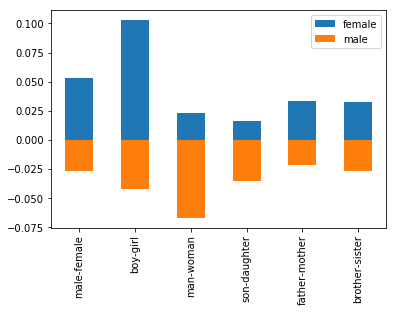

In [59]:
gender.plot.bar(stacked=True)

plt.ylabel('')
plt.show()

Here we have a much more mixed picture.

The problem with the pairs "girl"/"boy" and "woman"/"man" is that they may refer to third parties (eg. "I once met a girl who...). However, when those two columns are added together, there does not seem to be any evidence of any gender disparity. The final three pairs are even more likely to refer to third parties, and are only there for comparison purposes only.

On a slight digression, the distribution of the word choices is interesting: "girl" is much more widely used than "woman" whereas "man" is more widely used than "boy".

## Favorite authors and stories

Approximately one-fourth of users have favorited at least one author, and approximately one-third of users have favorited at least one story. In comparison, only ~2% are in a community.

Let's look at the distributions of the number of authors vs. stories a user would favorite.

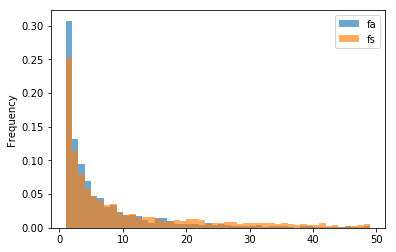

In [100]:
# examines distribution of favorited
df_active[['fa', 'fs']].plot.hist(normed=True, bins=np.arange(1, 50, 1), alpha = 0.65)

plt.show()

The right tail is much longer than is depicted above -- in the thousands. However, we cut it off at 50 to better show the distribution.

For the most part, the distributions are similar, with heavy right skew. The number of favorited authors is slightly more concentrated near 1, whereas the number of favorited stories is more dispersed.

## Stories written

We already know that ~20% of the users are authors. Of those authors, how many stories do they write?

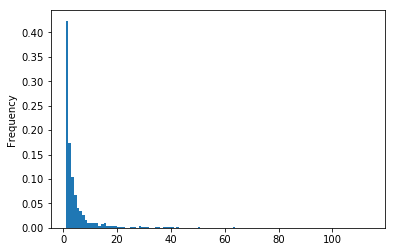

In [103]:
# examines distribution of stories written
df_active['st'].plot.hist(normed=True, bins=np.arange(1, np.max(df_active['st']), 1))

plt.show()

Over half of authors have published only 1-2 stories. About ~98% of authors had 10 stories or less.

## Thoughts and conclusions

Here is a summary of what we have discovered thus far:
* ~20% of users are authors
* The userbase has been increasing since the site has been founded.
* Over ~30% users have been identified as coming from the United States.
* ~25% of have written something in their profiles.
* Of the written profiles, the majority are between 0-200 words.
* Very roughly estimated, ~70% of the userbase is female.
* Approximately one-fourth of users have favorited at least one author.
* Approximately one-third of users have favorited at least one story.
* ~2% of users belong in a community.
* ~98% of authors have published 10 stories or less on the site.